# LIBRARY

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.genmod.families.family import Binomial
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
from matplotlib import font_manager, rc
[font for font in font_manager.fontManager.ttflist if 'Malgun Gothic' in font.name]
import seaborn as sns
sns.set(style="whitegrid", rc={'font.family':font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name(), 'figure.figsize': (15, 10)}, font_scale=2)

In [4]:
import warnings
warnings.filterwarnings('ignore')

# DATA

In [5]:
train = pd.read_csv('../Data/preprocess/train_preprocess2.csv')
valid = pd.read_csv('../Data/preprocess/valid_preprocess2.csv')
test = pd.read_csv('../Data/preprocess/test_preprocess2.csv')

In [6]:
train.sample()

,id,tag,year,month,day,dayofweek,year-month,year-month-day,hour,minute,...,cctv_dstnc,cctv_in_100m,fr_mn_cnt,fr_wthr_fclt_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,fire_yes
192,115566,train,2015,11,16,Monday,2015-11,2015-11-16,10,40,...,365,0,161.0,0,5672,340,8937,56,0,False


# MAKING DATASET

In [8]:
train.columns

Index(['id', 'tag', 'year', 'month', 'day', 'dayofweek', 'year-month',
       'year-month-day', 'hour', 'minute', 'second', 'jmk', 'lnd_ar', 'ttl_ar',
       'bldng_cnt', 'bldng_ar', 'mlt_us_yn(encode)', 'tmprtr', 'wnd_spd',
       'wnd_drctn', 'hmdt', 'address', 'address1', 'address2', 'hm_cnt',
       'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'cctv_dstnc', 'cctv_in_100m',
       'fr_mn_cnt', 'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc',
       'sft_emrgnc_bll_dstnc', 'ahsm_dstnc', 'no_tbc_zn_dstnc',
       'bldng_cnt_in_50m', 'fire_yes', 'fr_yn'],
      dtype='object')

In [9]:
# choose independent variables(Xs) which are useful!
# 트레이닝에 사용할 변수 목록을 적어주세요.
independents = ['month', 'day', 'hour', 'minute','lnd_ar', 'ttl_ar',
       'bldng_cnt', 'bldng_ar', 'mlt_us_yn(encode)', 'tmprtr', 'wnd_spd',
       'wnd_drctn', 'hmdt',  'hm_cnt',
       'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'cctv_dstnc', 'cctv_in_100m',
       'fr_mn_cnt', 'tbc_rtl_str_dstnc',
       'sft_emrgnc_bll_dstnc',  'no_tbc_zn_dstnc',
       'bldng_cnt_in_50m']

# 문자열 제외 'dayofweek', 'year-month','year-month-day', 'address', 'address1', 'address2', 'jmk'
# 관련 없는 열 제외 'id', 'second'(second가 0인게 많아서 fire_yes와 상관관계 높음) 
# 'fr_wthr_fclt_in_100m','ahsm_dstnc' 지역간 편차가 큰 애들 제외
# 독립변수
dependent = ['fire_yes'] # 종속변수

In [10]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_X = train[independents]
train_y = train[dependent]

test_X = test[independents]
valid_X = valid[independents]

In [11]:
def evaluation(y, pred):
    confusion = confusion_matrix(y, pred)
    accuracy = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    f1 = f1_score(y, pred)
    roc_score = roc_auc_score(y, pred)
    
    print('정확도(accuracy): {0: .4f}, 정밀도(precision): {1: .4f}, 재현율(recall): {2: 4f}, f1 score: {3: .4f}, auc값: {4: .4f}'.format(accuracy, precision, recall, f1, roc_score))

# 1. XGBoost & ROC 커브

In [12]:
model_xgb = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05, verbose = True).fit(train_X, train_y)
# model_xgb = XGBClassifier().fit(train_X, train_y) 
# 좋은 파라미터를 찾아봐야할 것 같음

In [13]:
model_xgb.feature_importances_

array([0.02865716, 0.02801775, 0.05065911, 0.02833175, 0.033534  ,
       0.0889696 , 0.04204478, 0.13067876, 0.03940847, 0.02927245,
       0.02897926, 0.02829831, 0.05105964, 0.03168887, 0.03259998,
       0.07635138, 0.02908396, 0.03059447, 0.05891659, 0.03271808,
       0.03736083, 0.034263  , 0.0285118 ], dtype=float32)

In [14]:
feature_importance = list(model_xgb.feature_importances_)
key = [ i for i in range(1, 23)]
dictionary = dict(zip(key, feature_importance))

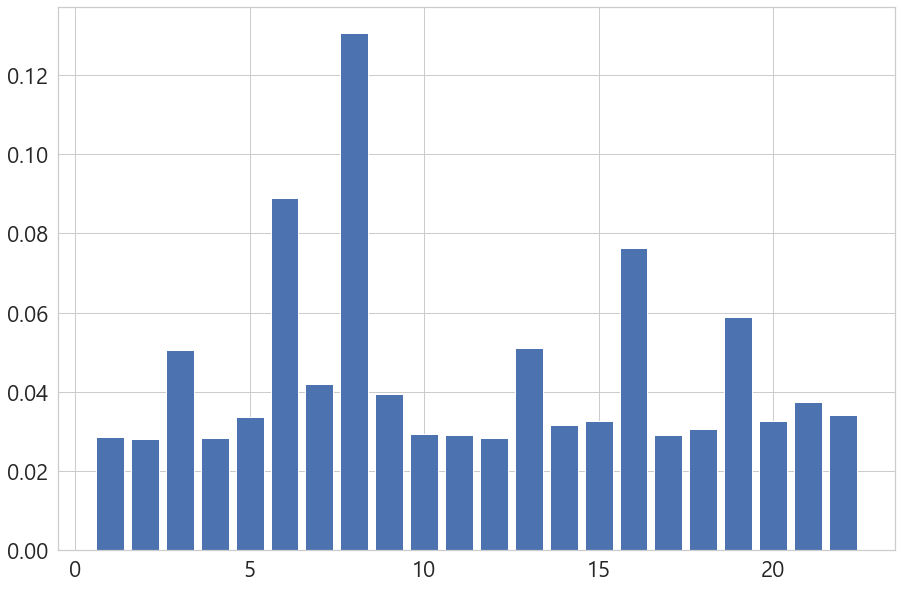

In [15]:
plt.bar(dictionary.keys(), dictionary.values())
plt.show()

3, 6, 8, 13, 16, 19 열이 화재 발생과 관련이 있음

In [16]:
pred_xgb = model_xgb.predict(valid_X)

In [19]:
print(classification_report(valid['fire_yes'], pred_xgb))

              precision    recall  f1-score   support

       False       0.85      0.96      0.90      5626
        True       0.62      0.25      0.36      1272

    accuracy                           0.83      6898
   macro avg       0.73      0.61      0.63      6898
weighted avg       0.81      0.83      0.80      6898



In [20]:
print('f1', metrics.f1_score(pred_xgb,valid['fire_yes']) )

f1 0.3604004449388209


In [18]:
evaluation(valid['fire_yes'], pred_xgb)

정확도(accuracy):  0.8333, 정밀도(precision):  0.6160, 재현율(recall):  0.254717, f1 score:  0.3604, auc값:  0.6094


In [32]:
fpr, tpr, thresholds = roc_curve(valid['fire_yes'], model_xgb.predict_proba(valid_X)[:, 1])

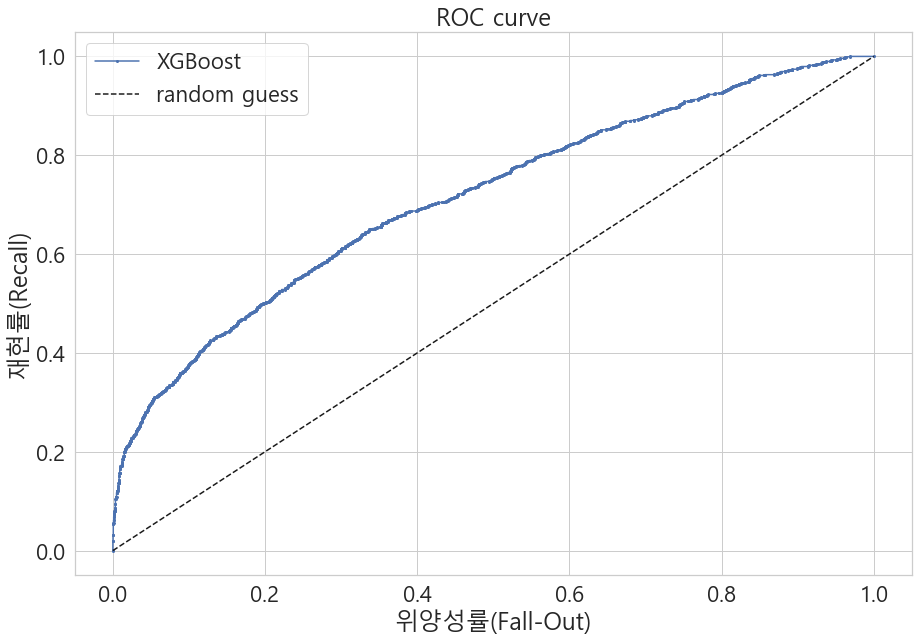

In [33]:
plt.plot(fpr, tpr, 'o-', ms=2, label="XGBoost")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC curve')
plt.show()

In [34]:
auc(fpr1, tpr1) # ROC 커브 면적

0.6646195113880523

# XGBoost DMatrix

In [60]:
dtrain = xgb.DMatrix(train_X, label=train_y)

In [61]:
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }

In [62]:
plst = param.items()

In [63]:
bst = xgb.train(plst,dtrain,)

In [68]:
dtest= xgb.DMatrix(valid_X)

In [69]:
ypred = bst.predict(dtest)

In [87]:
prediction_binomial_val = [1 if p>=0.4 else 0 for p in ypred]

In [88]:
print('f1', metrics.f1_score(prediction_binomial_val,valid['fire_yes']) )

f1 0.45784081954294725


In [89]:
evaluation(valid['fire_yes'], prediction_binomial_val)

정확도(accuracy):  0.8005, 정밀도(precision):  0.4589, 재현율(recall):  0.456761, f1 score:  0.4578, auc값:  0.6675


# XGBoost 성능 비교
max_depth 의사결정나무 모형 깊이 초모수를 달리해서 XGBoost 예측모형의 성능을 비교해본다.

In [35]:
f1_score_list = []

max_depth_list = [10, 15]

In [36]:
for max_depth in max_depth_list:
    xgb_model = XGBClassifier(max_depth=max_depth)
    xgb_pred = xgb_model.fit(train_X, train_y).predict(valid_X)
    xgb_f1_score = f1_score(xgb_pred,valid['fr_yn'])
    f1_score_list.append(xgb_f1_score)

KeyboardInterrupt: 

In [ ]:
xgb_df = pd.DataFrame({'tree depth':max_depth_list, 'f1_score':f1_score_list})
xgb_df.head()

# XGBoost 시각화
XGBoost 모형을 시각화함으로써 개발한 예측모형의 성능에 대해 더 깊은 이해를 가질 수 있다. xgb.plot_importance() 메쏘드에 XGBoost 모형객체를 넣어 변수중요도를 파악할 수 있다.

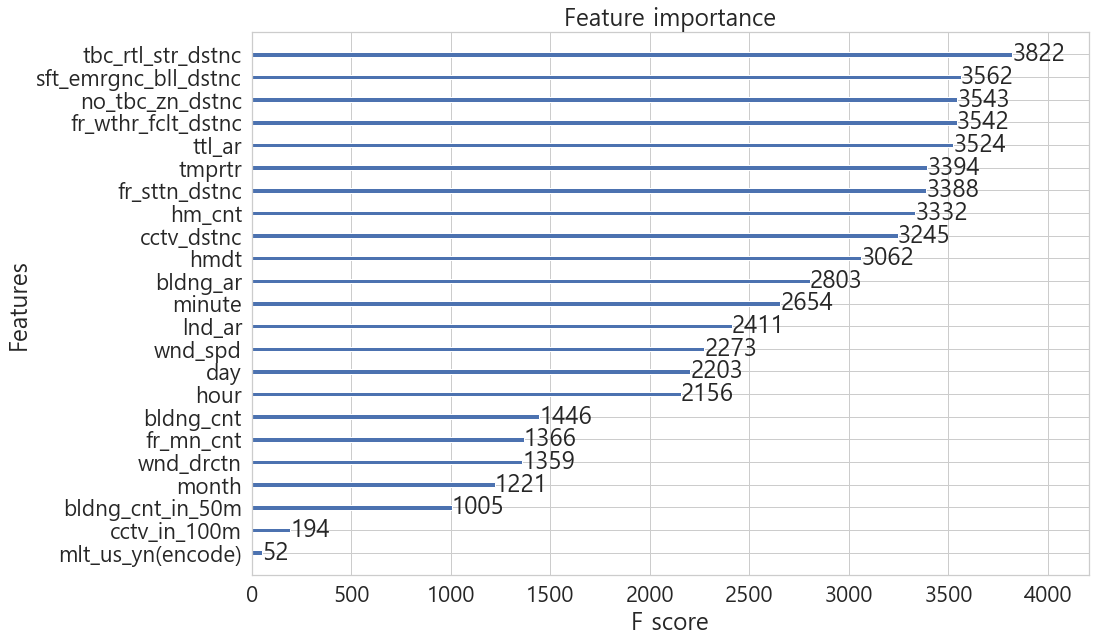

In [45]:
xgb.plot_importance(model_xgb)

# 2. 로지스틱 회귀분석 & ROC 커브

In [21]:
model_lr = LogisticRegression().fit(train_X, train_y)

In [24]:
pred_lr = model_lr.predict(valid_X)
# prediction2 = model2.predict(valid_X)

In [25]:
pred_lr

array([False, False, False, ..., False, False, False])

In [26]:
print('f1', metrics.f1_score(pred_lr,valid['fire_yes']) )

f1 0.1760113555713272


In [27]:
evaluation(valid['fire_yes'], pred_lr)

정확도(accuracy):  0.8317, 정밀도(precision):  0.9051, 재현율(recall):  0.097484, f1 score:  0.1760, auc값:  0.5476


In [28]:
fpr1, tpr1, thresholds1 = roc_curve(valid['fire_yes'], model_lr.predict_proba(valid_X)[:, 1])

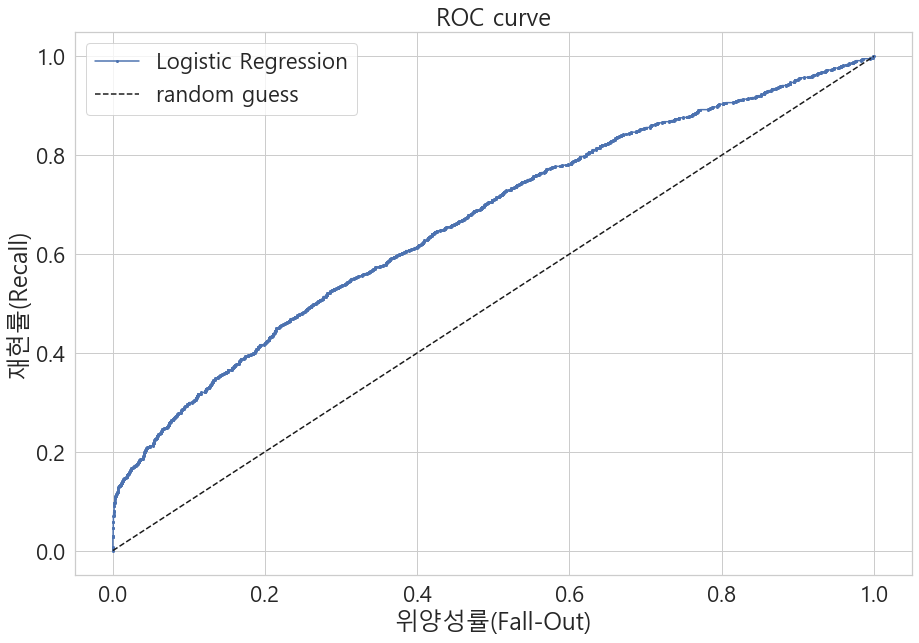

In [29]:
plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC curve')
plt.show()

In [30]:
auc(fpr1, tpr1) # ROC 커브 면적

0.6646195113880523

## 선형 회귀

In [100]:
model_reg = LinearRegression().fit(train_X, train_y)
# 대문자는 매트릭스, 소문자는 벡터

In [103]:
# x 계수
# x 계수의 의미를 해석하세요.
model_reg.coef_
# 피클래스가 한 계단 올라갈 때마다 죽음에 0.19배 가까워짐

array([[ 6.23359907e-04, -7.16793403e-05,  1.69645622e-03,
        -8.68243206e-05, -7.64814354e-09,  1.47777524e-07,
         1.33820246e-03,  3.05302288e-06,  3.87475868e-01,
         3.18098186e-04,  7.58087405e-03,  5.28528141e-06,
        -1.72506832e-03,  1.35804255e-07, -3.02263910e-06,
        -2.07209268e-05,  2.82131291e-06,  7.36810710e-03,
         1.29792978e-04, -4.77662709e-07,  4.89593907e-07,
        -4.84821945e-06,  3.64320546e-04]])

In [104]:
# 절편
model_reg.intercept_

array([0.21869984])

In [ ]:
reg.score(train_X, train_y, sample_weight=None)

In [105]:
pred_reg = model_reg.predict(valid_X)

In [122]:
pred_binomial = [1 if p>=0.2 else 0 for p in pred_reg]

In [123]:
print('f1', metrics.f1_score(pred_binomial,valid['fr_yn']) )

f1 0.361843858246736


# RANDOM FOREST

In [124]:
model_forest = RandomForestClassifier(random_state=42, n_estimators=10).fit(train_X, train_y)

In [125]:
model_forest.feature_importances_

array([0.02514199, 0.03466388, 0.03768561, 0.04007   , 0.04727033,
       0.09146986, 0.02551794, 0.09234866, 0.00125666, 0.04739237,
       0.0387478 , 0.02592874, 0.05491994, 0.04881427, 0.05001474,
       0.06465765, 0.04709763, 0.00847794, 0.03034936, 0.0508745 ,
       0.05512908, 0.06112974, 0.02104129])

In [126]:
pred_forest = model_forest.predict(valid_X)

In [127]:
pred_forest

array([False, False, False, ..., False, False, False])

In [128]:
print('f1', metrics.f1_score(pred_forest,valid['fr_yn']) )

f1 0.33171258779038354


In [129]:
evaluation(valid['fr_yn'], pred_forest)

정확도(accuracy):  0.8207, 정밀도(precision):  0.5302, 재현율(recall):  0.241352, f1 score:  0.3317, auc값:  0.5965


# VALIDATION 한 번에 돌리기

In [139]:
def train_and_val(model, num):
    a = model.fit(train_X, train_y)
    prediction_val = a.predict(valid_X)
    prediction_binomial_val = [1 if p>=num else 0 for p in prediction_val]
    print('f1:', f1_score(prediction_binomial_val,valid['fr_yn']) )
    return prediction_val

In [142]:
train_and_val(LogisticRegression(), 0.5)

f1: 0.1760113555713272


array([False, False, False, ..., False, False, False])

In [ ]:
train_and_val(RandomForestClassifier(n_estimators=700, oob_score=True, max_depth=12, min_samples_leaf=16, min_samples_split=8, n_jobs=-1), 0.5)

In [150]:
train_and_val(RandomForestClassifier(random_state=10, n_estimators=100, max_depth = 15), 0.5)

f1: 0.3759820426487093


array([False, False, False, ..., False, False,  True])

In [162]:
params = {
    'n_estimators': [100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 16],
    'min_samples_split': [8, 16, 24]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(train_X, train_y)

print("최적 하이퍼 파라미터: ", grid_cv.best_params_)
print("최고 예측 정확도: ", grid_cv.best_score_)

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도:  0.8805899545539018


In [161]:
params = {
    'n_estimators': [100, 300, 500]
}
rf_clf_1 = RandomForestClassifier(max_depth=12, min_samples_leaf=16, min_samples_split=8, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf_1, param_grid=params, cv = 3, n_jobs=-1)
grid_cv.fit(train_X, train_y)
print("최적 파라미터: ", grid_cv.best_params_)
print("최고 예측 정확도: ", grid_cv.best_score_)
best_model = grid_cv.best_estimator_
pred = best_model.predict(valid_X)
f1 = f1_score(valid['fire_yes'], pred)
print("f1 score: {0: .4f}".format(f1))

최적 파라미터:  {'n_estimators': 500}
최고 예측 정확도:  0.8771941680323022
f1 score:  0.3716


In [145]:
train_and_val(KNeighborsClassifier(n_neighbors = 4), 0.1)

f1: 0.2458547741566609


array([False, False, False, ..., False, False, False])

In [148]:
train_and_val(GaussianNB(), 0.5)

f1: 0.20083102493074792


array([False, False, False, ..., False, False, False])

In [ ]:
# train_and_val(SVC())